In [9]:
# Import libraries
import os
import numpy as np
import pandas as pd
from itertools import product

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers

from utils import load_image, get_centers, coord_transfm, mirror
from simplecnn import SimpleCNN
from resnet50 import ResNet50
from visualization import plot_history, plot_roi_centers, draw_roi

% matplotlib inline

In [10]:
# Define global parameters

IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHANNELS = 1
TRAIN_SIZE = 5614
TRAIN_PATH = '../input/bone-lab/trainset/'
TEST_PATH = '../input/bone-lab/testset/'
ROI_PATH = "../input/bone-lab/roi/"

### Load and pre-process data/images

In [11]:
# Read and load ROI data
df_centers_org = get_centers(ROI_PATH).sort_values(by='img_id') \
                                      .reset_index(drop=True)
print(df_centers_org.head())
df_centers = coord_transfm(df_centers_org)
print(df_centers.head())

         img_id  cx_pxl  cy_pxl        cx       cy
0  C00055300022     859    1059  0.419434  0.51709
1  C00055300023     859    1059  0.419434  0.51709
2  C00055300024     859    1059  0.419434  0.51709
3  C00055300025     859    1059  0.419434  0.51709
4  C00055300026     859    1059  0.419434  0.51709
         img_id  cx_pxl  cy_pxl       cx        cy
0  C00055300022     500     700  0.37594  0.526316
1  C00055300023     500     700  0.37594  0.526316
2  C00055300024     500     700  0.37594  0.526316
3  C00055300025     500     700  0.37594  0.526316
4  C00055300026     500     700  0.37594  0.526316


In [12]:
# Check every image matches the ROI file
images = pd.Series(sorted(os.listdir(TRAIN_PATH)))
img_ids = images.str.split('.').str[0]
assert df_centers.img_id.equals(img_ids), "Image lists don't match"

In [13]:
# Randomly pick training samples from the trainset
train_images = images.sample(TRAIN_SIZE, random_state=10)
train_img_ids = train_images.str.split('.').str[0]

# Load the selected images and reduce resolution
mat_images = load_image(TRAIN_PATH, train_images, IMG_HEIGHT, IMG_WIDTH)

# Store all images into a dataframe
df_train = pd.DataFrame(mat_images, 
                        columns=['pxl' + str(i) for i in range(mat_images.shape[1])])
df_train.insert(0, 'img_id', train_img_ids.values)
df_train = pd.merge(df_train, df_centers[['img_id', 'cx', 'cy']], 
                    on='img_id', validate="1:1")
print(df_train.head())
print(df_train.shape)

         img_id   pxl0   pxl1    ...     pxl1023        cx        cy
0  C00055410076   57.0   58.0    ...        57.0  0.380451  0.525564
1  C00055900056   57.0   59.0    ...        55.0  0.514286  0.489474
2  C00055680038  108.0  112.0    ...        99.0  0.447368  0.393985
3  C00055310107   50.0   52.0    ...        50.0  0.484211  0.592481
4  C00055750077   47.0   49.0    ...        47.0  0.391729  0.525564

[5 rows x 1027 columns]
(5614, 1027)


### Manual data augmentation

In [14]:
# Flip all train images around horizontal direction
df_train_hflip = mirror(df_train, 'h', IMG_HEIGHT, IMG_WIDTH)

# Flip all train images around horizontal direction
df_train_vflip = mirror(df_train, 'v', IMG_HEIGHT, IMG_WIDTH)

In [15]:
# Merge original and reproduced images
df_train = pd.concat([df_train, df_train_hflip, df_train_vflip],
                     ignore_index=True)
print("New dataframe's shape: {}".format(df_train.shape))
df_centers = df_train[['img_id', 'cx', 'cy']]

New dataframe's shape: (16842, 1027)


In [16]:
# Convert all images and their ROI centers into Numpy ndarray
X = df_train.drop(columns=['img_id', 'cx', 'cy']) \
            .values.reshape((-1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y = df_train[['cx', 'cy']].values
IDs = df_train.img_id.values

# Normalization
X /= 255.0

In [17]:
# Free RAM space
del df_train, df_train_hflip, df_train_vflip, mat_images

In [20]:
# Split train and validation sets
X_train, X_val, Y_train, Y_val, IDs_train, IDs_val \
= train_test_split(X, Y, IDs, test_size=0.05, random_state=1)

print("Trainset shape: {}".format(X_train.shape))
print("Validateset shape: {}".format(X_val.shape))

Trainset shape: (15999, 32, 32, 1)
Validateset shape: (843, 32, 32, 1)


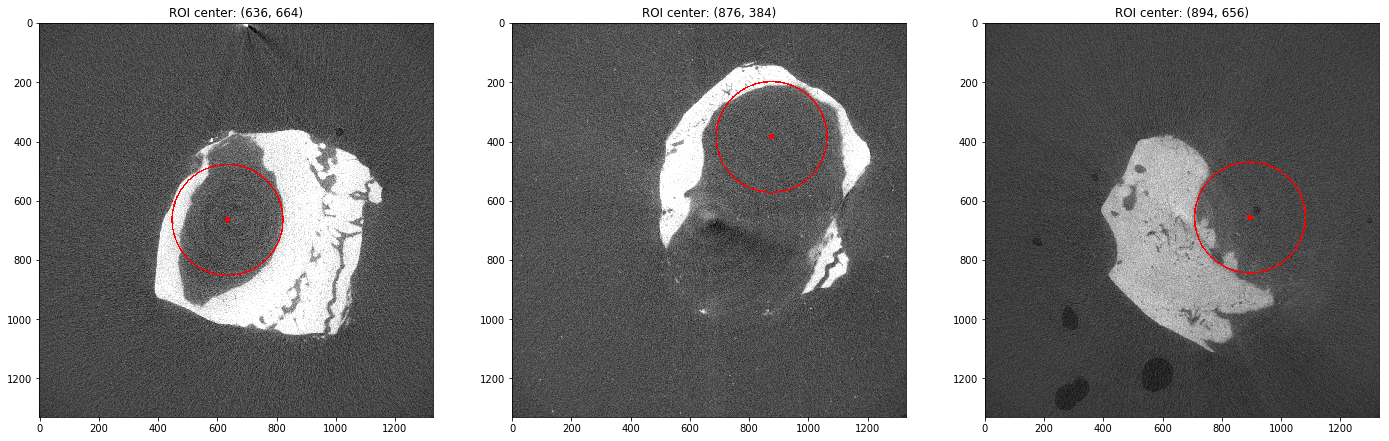

In [19]:
# Display some sample images with known ROI
select_disp = df_centers.iloc[:TRAIN_SIZE].sample(n=3)
img_list = select_disp['img_id'].values
true_centers = select_disp[['cx', 'cy']].values
draw_roi(TRAIN_PATH, img_list, true_centers)

### Baseline model: 7-layer CNN
**Architechture:** 

    Input -> ((Conv2D->relu) x 2 -> MaxPool2D) x 2 -> Flatten -> Dense x 2 -> Output

In [ ]:
# Create the model
simple_cnn = SimpleCNN(INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
simple_cnn.summary()

In [ ]:
# Fit the model with learning rate to be reduced when no progress
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)
hist_cnn = simple_cnn.fit(X_train, Y_train, batch_size=64, epochs=80,
                          validation_data=(X_val, Y_val), callbacks=[reduce_lr])

In [ ]:
# Evaluate the model with validation set
cnn_scores_train = simple_cnn.evaluate(X_train, Y_train, batch_size=64)
print("Score on trainset: {}".format(cnn_scores_train))

cnn_scores_val = simple_cnn.evaluate(X_val, Y_val, batch_size=64)
print("Score on validate set: {}".format(cnn_scores_val))

In [ ]:
cnn_pred = simple_cnn.predict(X_val, verbose=True)
cnn_results = pd.DataFrame(np.concatenate([cnn_pred, Y_val], axis=1), 
                           columns = ['cx_pred', 'cy_pred', 'cx', 'cy'])
cnn_results.insert(0, 'img_id', IDs_val)
print(cnn_results.head())

In [ ]:
# Visualize some results from the first model
orig = [img_id for img_id in cnn_results.img_id 
        if 'f' not in img_id]
orig_imgs = cnn_results[cnn_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=3)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi(TRAIN_PATH, img_list, true_centers, 
         pred_centers, rows=2, cols=3, model_name="Simple CNN")

In [ ]:
# Plot the ROI centers that human determined (red) along with that model detected
selt_dots = orig_imgs.sample(n=15)
img_list = selt_dots['img_id'].values
true_centers = (selt_dots[['cx', 'cy']].values * 1330).astype(int)
pred_centers = (selt_dots[['cx_pred', 'cy_pred']].values * 1330).astype(int)

plot_roi_centers(true_centers, pred_centers, "Simple CNN")

In [ ]:
# # Save the results of predictions
# cnn_results.to_csv("cnn_results.csv")

# # Save the model into HDF5 file
# simple_cnn.save("simple_cnn.h5")

In [ ]:
# Plot training history on loss
plot_history(hist_cnn, 'Simple CNN', ylim=(0.0, 0.06))

### Second model: ResNet-50
**Architecture**

    INPUT -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK x 2 -> CONVBLOCK -> 
    IDBLOCK x 3 -> CONVBLOCK -> IDBLOCK x 5 -> CONVBLOCK -> IDBLOCK x 2 -> AVGPOOL -> FC x 2 -> 
    Dropout -> Output



In [21]:
# Create the model instance
resnet = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                  lr_power=-2.523,
                  extra_layers=(1024, 256, 32),
                  dropouts=(0., 0., 0.))
resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   640         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________

In [ ]:
# Fit the model with learning rate to be reduced when no progress
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00003)
hist_resnet = resnet.fit(X_train, Y_train, batch_size=32, epochs=120,
                         validation_data=(X_val, Y_val), callbacks=[reduce_lr])

Instructions for updating:
Use tf.cast instead.
Train on 15999 samples, validate on 843 samples
Epoch 1/120
15999/15999 [==============================] - 49s 3ms/step - loss: 0.2738 - rmse: 0.3647 - max_error: 1.1820 - val_loss: 0.1481 - val_rmse: 0.2078 - val_max_error: 0.5956
Epoch 2/120
15999/15999 [==============================] - 34s 2ms/step - loss: 0.1036 - rmse: 0.1452 - max_error: 0.5209 - val_loss: 0.0765 - val_rmse: 0.0962 - val_max_error: 0.2739
Epoch 3/120
15999/15999 [==============================] - 34s 2ms/step - loss: 0.1024 - rmse: 0.1381 - max_error: 0.4741 - val_loss: 0.0915 - val_rmse: 0.1255 - val_max_error: 0.4305
Epoch 4/120
15999/15999 [==============================] - 34s 2ms/step - loss: 0.0651 - rmse: 0.0966 - max_error: 0.3828 - val_loss: 0.0575 - val_rmse: 0.0802 - val_max_error: 0.2818
Epoch 5/120
15999/15999 [==============================] - 34s 2ms/step - loss: 0.0498 - rmse: 0.0787 - max_error: 0.3304 - val_loss: 0.0396 - val_rmse: 0.0549 - val_ma

In [ ]:
# Evaluate the model with validation set
ResNet_scores_train = resnet.evaluate(X_train, Y_train, batch_size=512)
print("Score on trainset: {}".format(ResNet_scores_train))

ResNet_scores_val = resnet.evaluate(X_val, Y_val, batch_size=32)
print("Score on validate set: {}".format(ResNet_scores_val))

In [ ]:
ResNet_pred = resnet.predict(X_val, verbose=True)
ResNet_results = pd.DataFrame(np.concatenate([ResNet_pred, Y_val], axis=1), 
                              columns = ['cx_pred', 'cy_pred', 'cx', 'cy'])
ResNet_results.insert(0, 'img_id', IDs_val)
print(ResNet_results.head())

In [ ]:
# Visualize some results from the first model
orig = [img_id for img_id in ResNet_results.img_id 
        if 'f' not in img_id]
orig_imgs = ResNet_results[ResNet_results.img_id.isin(orig)]
selt_imgs = orig_imgs.sample(n=3)
img_list = selt_imgs['img_id'].values
true_centers = selt_imgs[['cx', 'cy']].values
pred_centers = selt_imgs[['cx_pred', 'cy_pred']].values

draw_roi(TRAIN_PATH, img_list, true_centers, pred_centers, 
         rows=2, cols=3, model_name="ResNet50")

In [ ]:
# Plot the ROI centers that human determined (red) along with that model detected
selt_dots = orig_imgs.sample(n=15)
img_list = selt_dots['img_id'].values
true_centers = (selt_dots[['cx', 'cy']].values * 1330).astype(int)
pred_centers = (selt_dots[['cx_pred', 'cy_pred']].values * 1330).astype(int)

plot_roi_centers(true_centers, pred_centers, "ResNet-50")

In [ ]:
# Save the results
ResNet_results.to_csv("ResNet_results.csv")

# Save the model into HDF5 file
resnet.save("ResNet50_BoneCT.h5")

In [ ]:
# Plot training history on loss
plot_history(hist_resnet, 'ResNet-50', ylim=(0.0, 0.1))

### Hyper-parameters tunning for ResNet-50

** Grid search for best hyper-parameters **

In [ ]:
# Conduct randomized grid search to find appropriate hyper-parameters for the ResNet-50 model

resnet = KerasRegressor(build_fn = ResNet50, 
                        input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                        epochs = 50,
                        verbose = True)

lr_power = stats.uniform(loc=-3.3, scale=1.3)
batch_size = np.power(2, range(3, 11))
dense_1 = [1024, 512, 256]
dense_2 = [256, 128, 56]
dense_3 = [56, 32, 16]
extra_layers = list(product(dense_1, dense_2, dense_3))
dropouts = list(product([0.5, 0.25, 0.0], repeat=3))

hparam_dist = {'lr_power': lr_power,
               'batch_size': batch_size,
               'extra_layers': extra_layers,
               'dropouts': dropouts
              }

hparam_search = RandomizedSearchCV(estimator=resnet,
                                   param_distributions=hparam_dist,
                                   n_iter=16, cv=2, verbose=True)

hparam_search.fit(X_train, Y_train)

In [ ]:
# Show the results

print("Best mean loss: {:.5f} with\n {}".format(-hparam_search.best_score_, hparam_search.best_params_))
means = -hparam_search.cv_results_['mean_test_score']
stds = hparam_search.cv_results_['std_test_score']
params = hparam_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("___" * 10)
    print("%.5f (%.3f) with\n %r" % (mean, stdev, param))